In [ ]:
library(rstan)
library(bayesplot)


rstan_options(auto_write =TRUE)
options(mc.cores = parallel::detectCores())

In [ ]:
data <- read.csv("../input/owarihouse-3/OwariHouse_3.csv")
head(data)

In [ ]:
formula_lm <- formula(Sales ~ Dist_to_Starion + Site_Area + Building_Area + Age + Dist_to_Nagoya)
X <- model.matrix(formula_lm, data)
Y <- data$Sales
ggplot(data=data,
       mapping = aes(x = Sales , y =..density..))+
       geom_histogram(alpha=0.5 )
      

In [84]:
stan_model = "
data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  vector[N] Y;          // 応答変数 
  matrix[N, K] X;       // デザイン行列 
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
  real<lower=0> sigma;  // データのばらつきを表す標準偏差
} 

model { 
  Y ~ normal(X * b, sigma);
} 

generated quantities { 
  vector[N] pred;
  for (i in 1:N){
    pred[i] = normal_rng(X[i] * b, sigma);
  }
}
"


In [88]:
stan_model_log = "
data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  vector[N] Y;          // 応答変数 
  matrix[N, K] X;       // デザイン行列 
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
  real<lower=0> sigma;  // データのばらつきを表す標準偏差
} 

model { 
  Y ~ lognormal(X * b, sigma);
} 

generated quantities { 
  vector[N] pred;
  for (i in 1:N){
    pred[i] = lognormal_rng(X[i] * b, sigma);
  }
}
"

In [ ]:
data_design <- list(N = nrow(data), K = 6, Y = data$Sales ,X = X)

In [85]:
mcmc_normal <- stan(
    model_code = stan_model,
    data = data_design,
    seed = 1
)


In [89]:
mcmc_lognormal <- stan(
    model_code = stan_model_log,
    data = data_design,
    seed = 1
)


In [90]:
mcmc_sample_lognormal <- rstan::extract(mcmc_lognormal, permuted = FALSE)
print(mcmc_lognormal, probs = c(0.025, 0.5,0.975))

Inference for Stan model: b44c834f1cead69e64b903c0acfa0771.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean      sd    2.5%      50%    97.5% n_eff Rhat
b[1]          8.03    0.00    0.06    7.90     8.02     8.15  1264    1
b[2]          0.00    0.00    0.00   -0.01     0.00     0.00  3101    1
b[3]          0.00    0.00    0.00    0.00     0.00     0.00  4145    1
b[4]          0.00    0.00    0.00    0.00     0.00     0.00  2546    1
b[5]         -0.02    0.00    0.00   -0.03    -0.02    -0.02  3607    1
b[6]         -0.02    0.00    0.00   -0.02    -0.02    -0.01  1792    1
sigma         0.34    0.00    0.01    0.32     0.34     0.36  1090    1
pred[1]    1343.50    7.43  473.71  656.72  1260.43  2494.41  4063    1
pred[2]    2078.16   11.71  718.93 1021.92  1961.10  3830.92  3767    1
pred[3]    2037.22   11.12  714.81  966.84  1918.14  3735.32  4132    1
pred[4]    2670.17   15.30  92

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



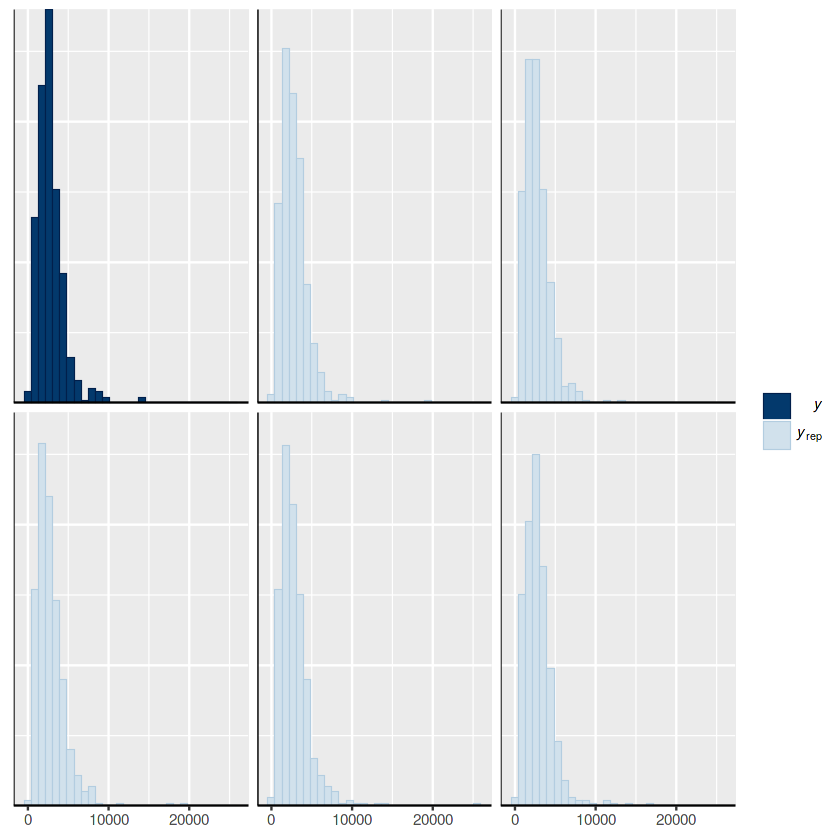

In [91]:
y_rep_lognormal =rstan::extract(mcmc_lognormal)$pred
ppc_hist(y = data$Sales , yrep=y_rep_lognormal[1:5, ])

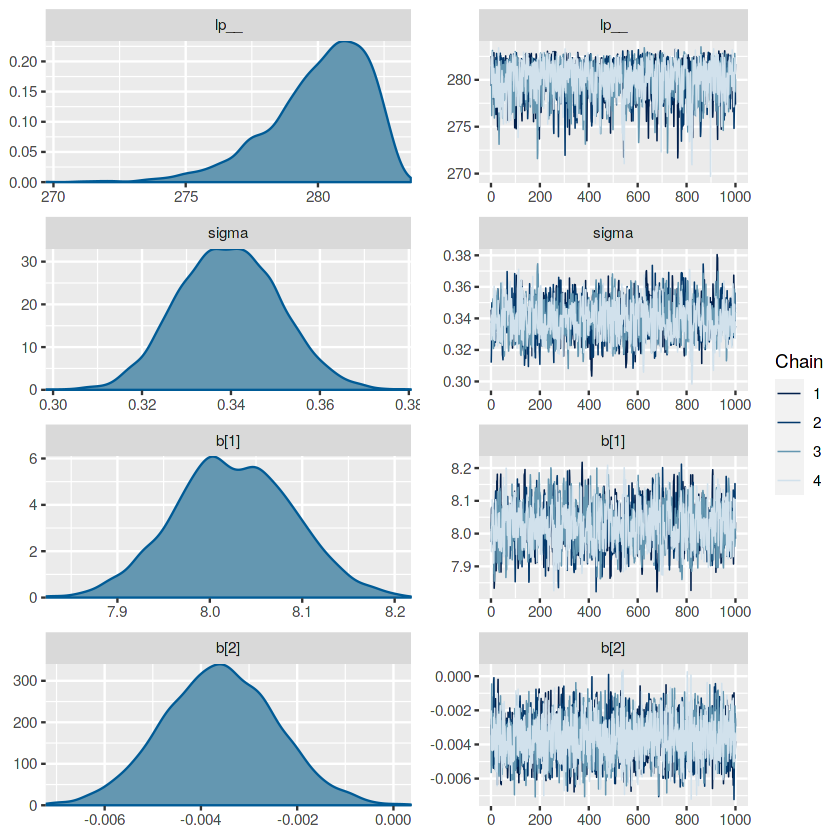

In [92]:
mcmc_combo(
    mcmc_sample_lognormal,
    pars = c("lp__","sigma",'b[1]','b[2]')
)

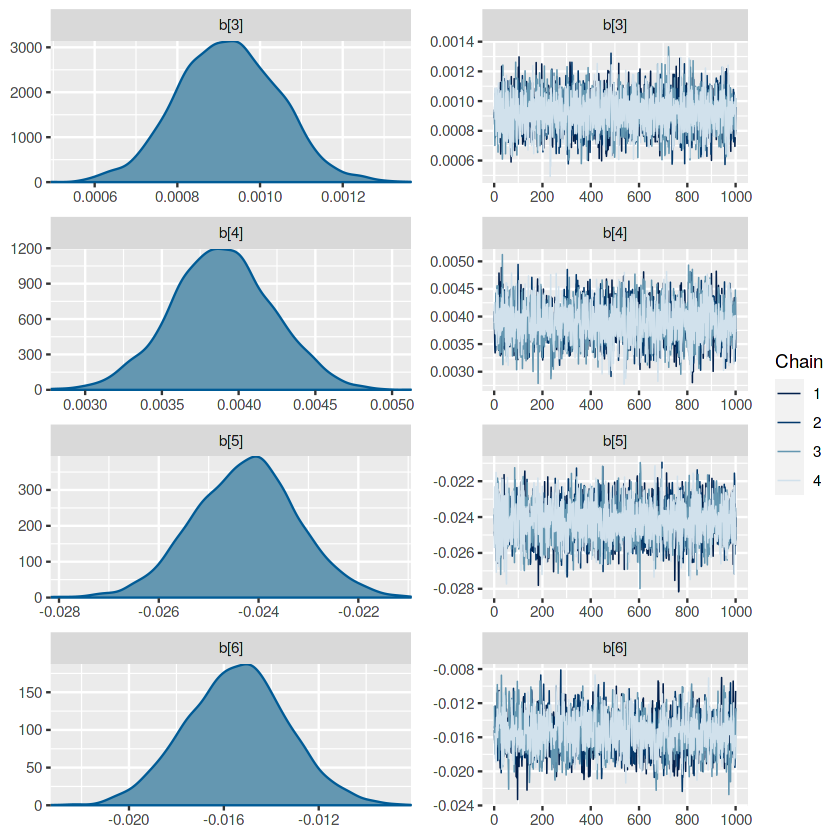

In [93]:
mcmc_combo(
    mcmc_sample_lognormal,
    pars = c('b[3]','b[4]','b[5]','b[6]')
)

In [86]:
mcmc_sample_normal <- rstan::extract(mcmc_normal, permuted = FALSE)
print(mcmc_normal, probs = c(0.025, 0.5,0.975))

Inference for Stan model: 6a2f3a9dd6b8bd0b520b18dc9403ea38.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean      sd     2.5%      50%    97.5% n_eff Rhat
b[1]       2796.46    4.02  198.02  2399.95  2797.05  3182.15  2426    1
b[2]        -14.83    0.07    3.71   -22.28   -14.75    -7.51  2981    1
b[3]          2.56    0.01    0.38     1.84     2.55     3.32  3060    1
b[4]         14.14    0.02    1.02    12.07    14.11    16.17  3037    1
b[5]        -51.27    0.05    3.25   -57.78   -51.24   -44.99  3778    1
b[6]        -41.78    0.13    6.64   -55.19   -41.80   -28.99  2631    1
sigma      1061.46    0.54   34.24   997.43  1060.47  1130.70  3960    1
pred[1]    1229.83   16.40 1062.21  -813.74  1246.30  3239.54  4195    1
pred[2]    2318.24   17.74 1076.57   193.71  2308.64  4436.45  3682    1
pred[3]    2291.20   16.67 1056.83   216.44  2285.79  4369.05  4021    1
pred[4]    2745.89 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



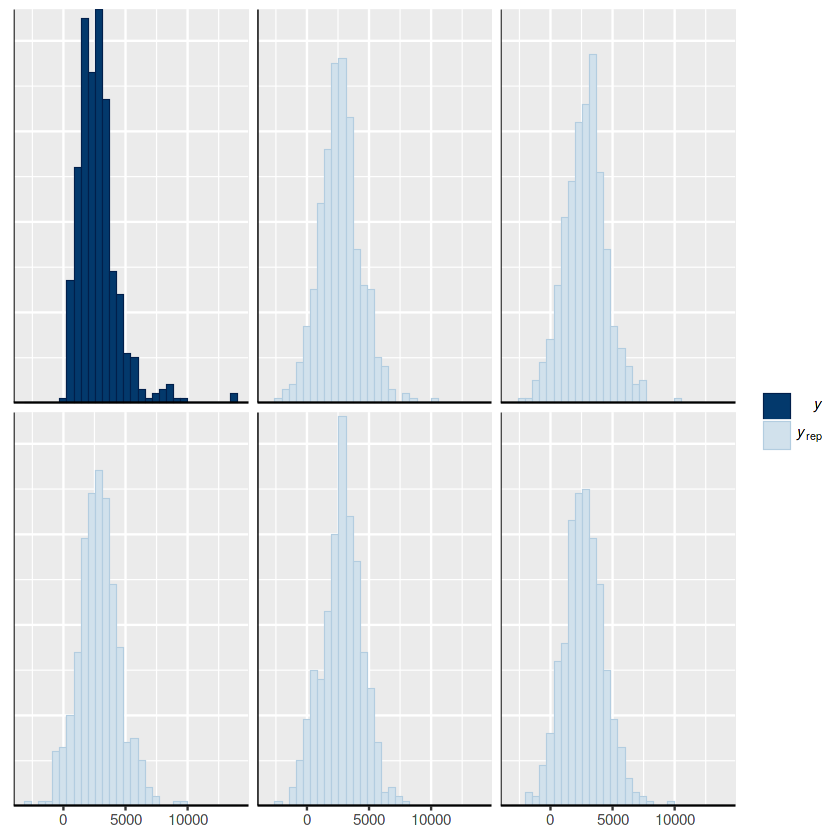

In [87]:
y_rep_normal =rstan::extract(mcmc_normal)$pred
ppc_hist(y = data$Sales , yrep=y_rep_normal[1:5, ])

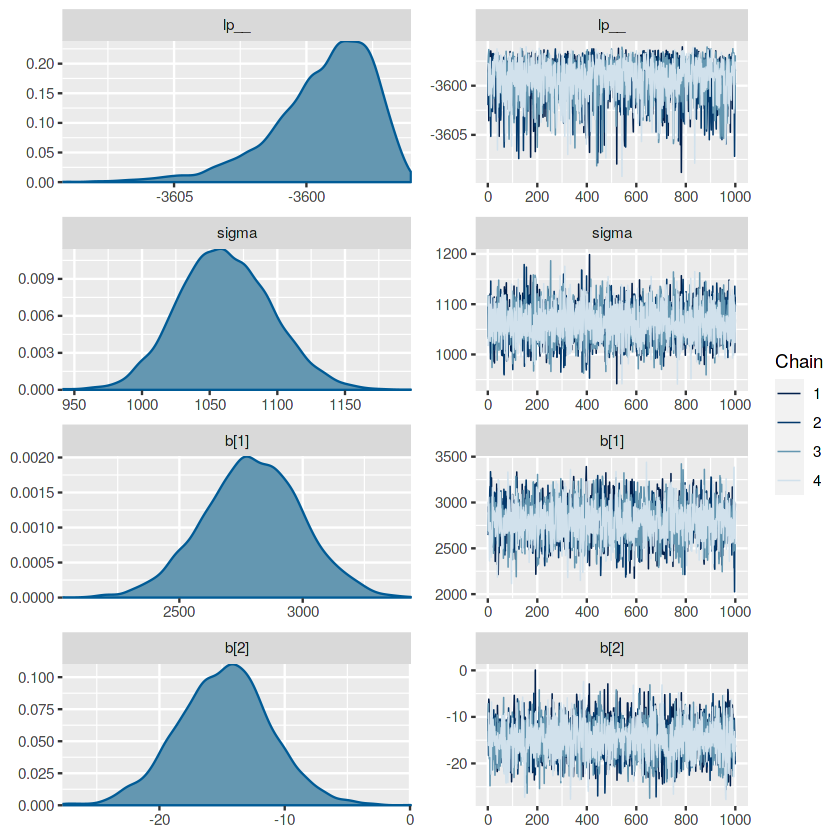

In [94]:
mcmc_combo(
    mcmc_sample_normal,
    pars = c("lp__","sigma",'b[1]','b[2]')
)

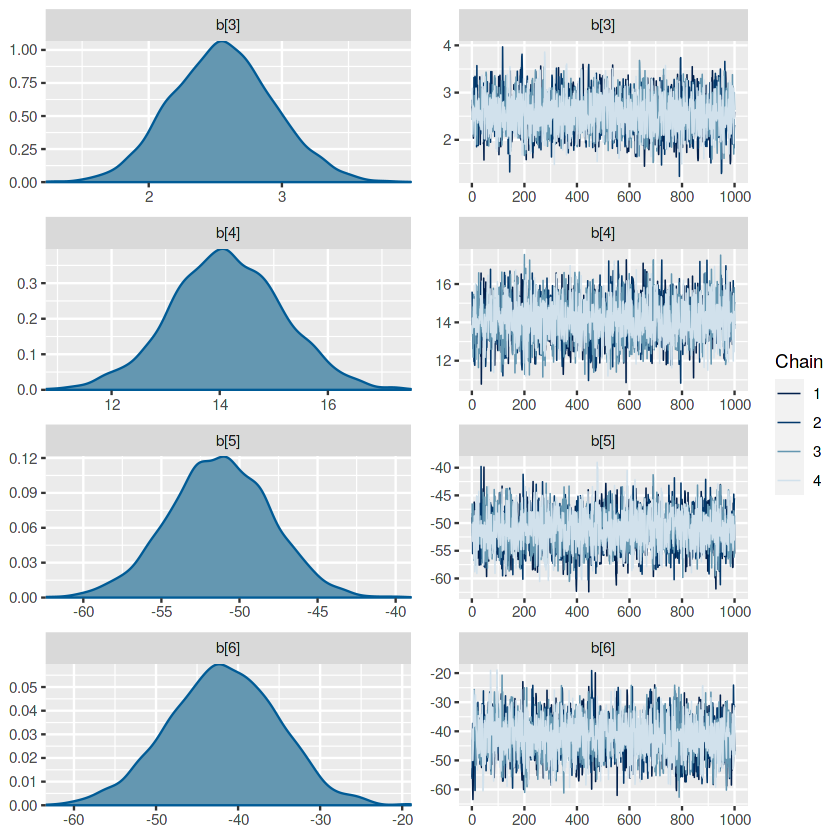

In [95]:
mcmc_combo(
    mcmc_sample_normal,
    pars = c('b[3]','b[4]','b[5]','b[6]')
)